In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import re

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
import sys
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '../../'))
sys.path.append(project_root)

### Data Loading and Preprocessing

In [4]:
DATASET_PATH = os.path.join(
    project_root,
    'nepali_sentiment_analysis',
    'dataset',
    'processed',
    'combined_cleaned_data.csv'
)

In [5]:
df = pd.read_csv(DATASET_PATH)
print("Dataset Loaded Successfully!")
df.head()

Dataset Loaded Successfully!


,Sentiment,Sentences
0,0,पुन निर्वाचन गरे यस्तै हुने हो
1,0,निर्वाचन कति गरिरहने
2,0,शासन व्यवस्था चुनाव पध्दति फेर्नु एउटा उपचार हो
3,0,क्या अचम्मकाे नगरपालिका डाेजरम्यान बालेनकाे
4,0,प्युठान नगरपालिका नेपाल स्वयंसेवक राष्ट्रिय सम...


#### Sentiment Distribution

In [6]:
print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())


Sentiment Distribution:
Sentiment
1    15951
2    14422
0    13263
Name: count, dtype: int64


#### Visualization

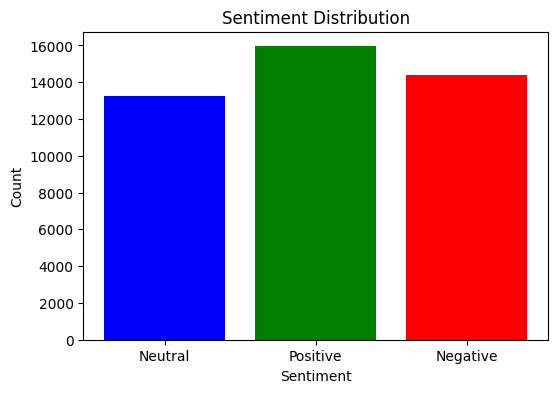

In [7]:
from nepali_sentiment_analysis.utils import visualization

labels_dict = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}

visualization.plot_sentiment_distribution(
    df, 'Sentiment Distribution', labels_dict
)


#### Preprocessing

In [8]:
from utils.preprocess import preprocess

tqdm.pandas()
df["Processed_Sentences"] = df["Sentences"].progress_apply(lambda x: preprocess(x))

print("\nSample Preprocessed Text:")
df.head()


100%|██████████| 43636/43636 [00:00<00:00, 52698.92it/s]


Sample Preprocessed Text:


,Sentiment,Sentences,Processed_Sentences
0,0,पुन निर्वाचन गरे यस्तै हुने हो,पुन निर्वाचन गरे यस्तै हुने हो
1,0,निर्वाचन कति गरिरहने,निर्वाचन कति गरिरहने
2,0,शासन व्यवस्था चुनाव पध्दति फेर्नु एउटा उपचार हो,शासन व्यवस्था चुनाव पध्दति फेर्नु एउटा उपचार हो
3,0,क्या अचम्मकाे नगरपालिका डाेजरम्यान बालेनकाे,क्या अचम्मकाे नगरपालिका डाेजरम्यान बालेनकाे
4,0,प्युठान नगरपालिका नेपाल स्वयंसेवक राष्ट्रिय सम...,प्युठान नगरपालिका नेपाल स्वयंसेवक राष्ट्रिय सम...


#### Embedding


In [9]:
from utils.embedding import Embeddings

embedding_path = "models/nepali_embeddings_word2vec.kv"
word_vectors = Embeddings().load_vector()

embedding_dim = word_vectors.vector_size
print(f"Loaded embeddings with dimension: {embedding_dim}")

Loaded embeddings with dimension: 300


In [10]:
# Sentence to embedding conversion with improved handling
max_length = 32


def sentence_to_embedding(sentence):
    tokens = sentence.split()
    embeddings = [
        word_vectors[token] if token in word_vectors else np.zeros(
            embedding_dim)
        for token in tokens
    ]
    if len(embeddings) > max_length:
        embeddings = embeddings[:max_length]
    else:
        embeddings += [np.zeros(embedding_dim)] * \
            (max_length - len(embeddings))
    return np.array(embeddings)


embedded_sentences = np.array(
    df["Processed_Sentences"].apply(sentence_to_embedding).tolist())
sentiments = df["Sentiment"].values

print(f"Embedded Sentences Shape: {embedded_sentences.shape}")

Embedded Sentences Shape: (43636, 32, 300)


### Model Definition

In [11]:
import math


class SentimentTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, num_classes, d_ff, max_len, dropout):
        super(SentimentTransformer, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout)
             for _ in range(num_layers)]
        )
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)
        return self.classifier(x)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, d_model, 2)
                             * (math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output = self.self_attn(x, x, x)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self.feed_forward(x))
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v):
        bs = q.size(0)
        q = self.q_linear(q).view(bs, -1, self.num_heads,
                                  self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(bs, -1, self.num_heads,
                                  self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(bs, -1, self.num_heads,
                                  self.d_k).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn = F.softmax(scores, dim=-1)
        output = torch.matmul(attn, v).transpose(
            1, 2).contiguous().view(bs, -1, self.num_heads * self.d_k)
        return self.out(output)

### Data Preparation for Training

In [12]:

from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert data to tensors
embedded_sentences_tensor = torch.tensor(
    embedded_sentences, dtype=torch.float32)
sentiments_tensor = torch.tensor(sentiments, dtype=torch.long)

In [13]:
# Create dataset and split
dataset = TensorDataset(embedded_sentences_tensor, sentiments_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [14]:
# Create DataLoader for batch processing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [15]:
# Print dataset sizes
print(f"Training Set Size: {train_size}")
print(f"Validation Set Size: {val_size}")

Training Set Size: 34908
Validation Set Size: 8728


### Model Initialization and Hyperparameters

In [16]:
# Model parameters
d_model = embedding_dim
num_heads = 4
num_layers = 2
num_classes = 3
d_ff = 128
dropout = 0.1
max_len = max_length

In [17]:
# Class weights (to handle class imbalance)
class_counts = df['Sentiment'].value_counts().sort_index().values
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights_tensor = torch.tensor(
    class_weights, 
    dtype=torch.float32
    ).to(device)

In [18]:
# Instantiate the model
model = SentimentTransformer(
    d_model, num_heads, num_layers, num_classes, d_ff, max_len, dropout
).to(device)

In [19]:
# Define weighted loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

c:\Users\Suyash Shrestha\AppData\Local\pypoetry\Cache\virtualenvs\nepali-news-algorithms-J5nQd0Uu-py3.12\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
no_improvement_epochs = 0

### Training Loop with Early Stopping

In [22]:
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_predictions / len(val_loader.dataset)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
        f"Validation Accuracy: {val_accuracy:.4f}"
    )

    # Update scheduler and check early stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation loss improved. Model saved.")
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1/50, Train Loss: 0.7619, Validation Loss: 0.7192, Validation Accuracy: 0.6849
Validation loss improved. Model saved.
Epoch 2/50, Train Loss: 0.7329, Validation Loss: 0.7383, Validation Accuracy: 0.6934
Epoch 3/50, Train Loss: 0.7206, Validation Loss: 0.7371, Validation Accuracy: 0.6841
Epoch 4/50, Train Loss: 0.7171, Validation Loss: 0.7374, Validation Accuracy: 0.6913
Epoch 5/50, Train Loss: 0.7136, Validation Loss: 0.7322, Validation Accuracy: 0.6833
Epoch 6/50, Train Loss: 0.6863, Validation Loss: 0.6967, Validation Accuracy: 0.7002
Validation loss improved. Model saved.
Epoch 7/50, Train Loss: 0.6732, Validation Loss: 0.6959, Validation Accuracy: 0.7002
Validation loss improved. Model saved.
Epoch 8/50, Train Loss: 0.6669, Validation Loss: 0.6942, Validation Accuracy: 0.7020
Validation loss improved. Model saved.
Epoch 9/50, Train Loss: 0.6632, Validation Loss: 0.6959, Validation Accuracy: 0.7029
Epoch 10/50, Train Loss: 0.6549, Validation Loss: 0.6880, Validation Accuracy: 

### Training Visualization

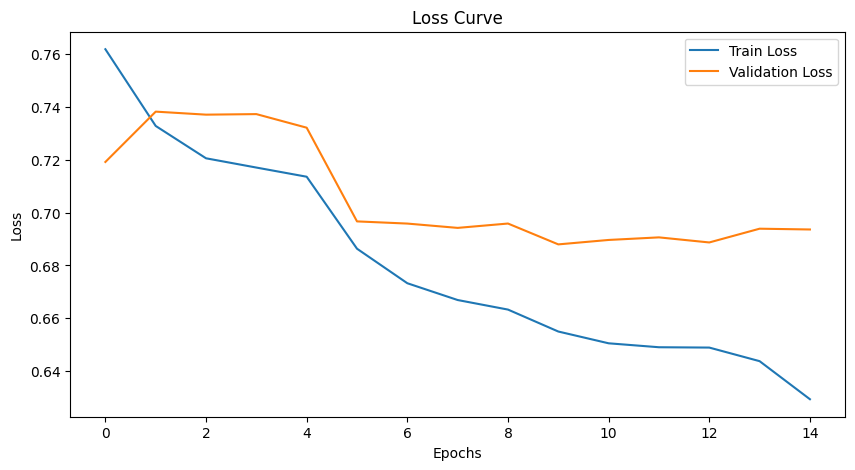

In [23]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

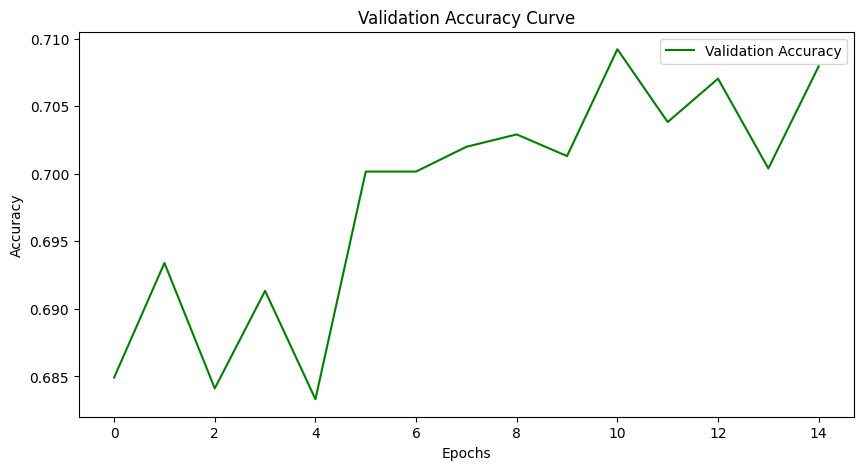

In [24]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.title("Validation Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Evaluation

In [25]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
print("Best model loaded for evaluation.")

Best model loaded for evaluation.


C:\Users\Suyash Shrestha\AppData\Local\Temp\ipykernel_18388\2669732529.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth")

In [26]:

# Evaluate model on validation set
predictions, actuals = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

In [27]:
# Calculate metrics
f1 = f1_score(actuals, predictions, average="weighted")
precision = precision_score(actuals, predictions, average="weighted")
recall = recall_score(actuals, predictions, average="weighted")
conf_matrix = confusion_matrix(actuals, predictions)

In [28]:
# Display metrics
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(classification_report(actuals, predictions,
      target_names=["Neutral", "Positive", "Negative"]))

F1 Score: 0.7014
Precision: 0.7025
Recall: 0.7013

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.73      0.68      0.71      2626
    Positive       0.70      0.69      0.70      3168
    Negative       0.68      0.73      0.70      2934

    accuracy                           0.70      8728
   macro avg       0.70      0.70      0.70      8728
weighted avg       0.70      0.70      0.70      8728



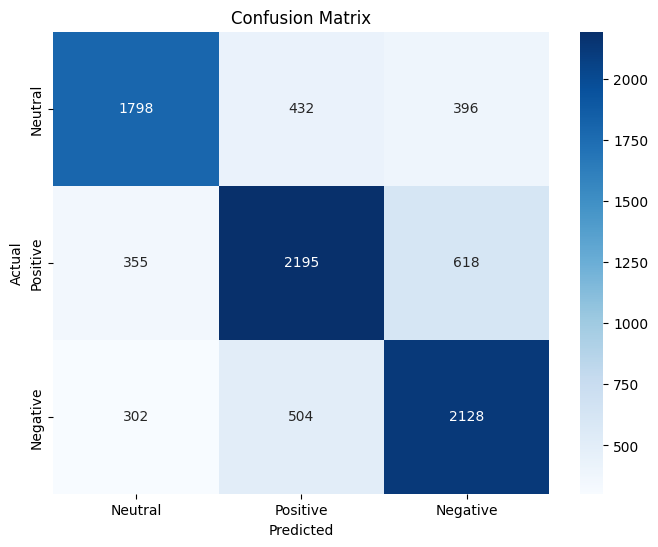

In [29]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["Neutral", "Positive", "Negative"],
    yticklabels=["Neutral", "Positive", "Negative"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()